# Import Libraries

In [34]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import r2_score
from torch.nn.functional import l1_loss

# Import Data

In [35]:
# Define the ticker symbol for Bitcoin
ticker = 'BTC-USD'

# Get historical market data
hist = yf.Ticker(ticker).history(period="max")

# Making the 'Date' as the index
hist.index = pd.to_datetime(hist.index)

# Drop the "Dividends" column and "Stock Splits" column
hist.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Print the data
print(hist.tail())

                                   Open          High           Low  \
Date                                                                  
2024-05-23 00:00:00+00:00  69121.304688  70041.273438  66356.953125   
2024-05-24 00:00:00+00:00  67928.132812  69220.296875  66622.671875   
2024-05-25 00:00:00+00:00  68526.921875  69579.320312  68515.820312   
2024-05-26 00:00:00+00:00  69264.289062  69506.226562  68183.890625   
2024-05-27 00:00:00+00:00  68476.765625  69202.375000  68266.148438   

                                  Close       Volume  
Date                                                  
2024-05-23 00:00:00+00:00  67929.562500  41895680979  
2024-05-24 00:00:00+00:00  68526.101562  29197308153  
2024-05-25 00:00:00+00:00  69265.945312  15473071741  
2024-05-26 00:00:00+00:00  68518.093750  15628433737  
2024-05-27 00:00:00+00:00  68837.453125  19894177792  


# Set Inputs and Outputs

In [17]:
X, y = hist.drop(columns=['Close']), hist.Close.values
X,y

(                                   Open          High           Low  \
 Date                                                                  
 2014-09-17 00:00:00+00:00    465.864014    468.174011    452.421997   
 2014-09-18 00:00:00+00:00    456.859985    456.859985    413.104004   
 2014-09-19 00:00:00+00:00    424.102997    427.834991    384.532013   
 2014-09-20 00:00:00+00:00    394.673004    423.295990    389.882996   
 2014-09-21 00:00:00+00:00    408.084991    412.425995    393.181000   
 ...                                 ...           ...           ...   
 2024-05-23 00:00:00+00:00  69121.304688  70041.273438  66356.953125   
 2024-05-24 00:00:00+00:00  67928.132812  69220.296875  66622.671875   
 2024-05-25 00:00:00+00:00  68526.921875  69579.320312  68515.820312   
 2024-05-26 00:00:00+00:00  69264.289062  69506.226562  68183.890625   
 2024-05-27 00:00:00+00:00  68476.765625  69202.375000  68266.148438   
 
                                 Volume  
 Date               

# Standardize Features

In [18]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))
X_trans,y_trans

(array([[-0.87484602, -0.87499127, -0.87594896, -0.89473717],
        [-0.87534084, -0.87559869, -0.87816714, -0.89403922],
        [-0.87714102, -0.87715698, -0.87977907, -0.89386058],
        ...,
        [ 2.86548108,  2.8354169 ,  2.96393779, -0.09148267],
        [ 2.90600344,  2.83149267,  2.94521154, -0.08340636],
        [ 2.86272472,  2.81517963,  2.94985222,  0.13170848]]),
 array([[0.00383005],
        [0.00337886],
        [0.00297225],
        ...,
        [0.94763687],
        [0.93737904],
        [0.94106768]]))

# Model Training

In [19]:
model = SARIMAX(y_trans, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 3541
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               10652.246
Date:                            Mon, 27 May 2024   AIC                         -21294.491
Time:                                    13:30:59   BIC                         -21263.649
Sample:                                         0   HQIC                        -21283.489
                                           - 3541                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1514      0.180      0.841      0.401      -0.202       0.504
ma.L1         -0.1969      0.179   

# Forecasting

In [39]:
# Forecasting for tomorrow
forecast_steps = 1
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Inverse transform the forecasted value
predicted_price_scaled = mm.inverse_transform(forecast_mean.reshape(-1, 1)).flatten()
forecast_ci_transformed = mm.inverse_transform(forecast_ci)

# Plotting

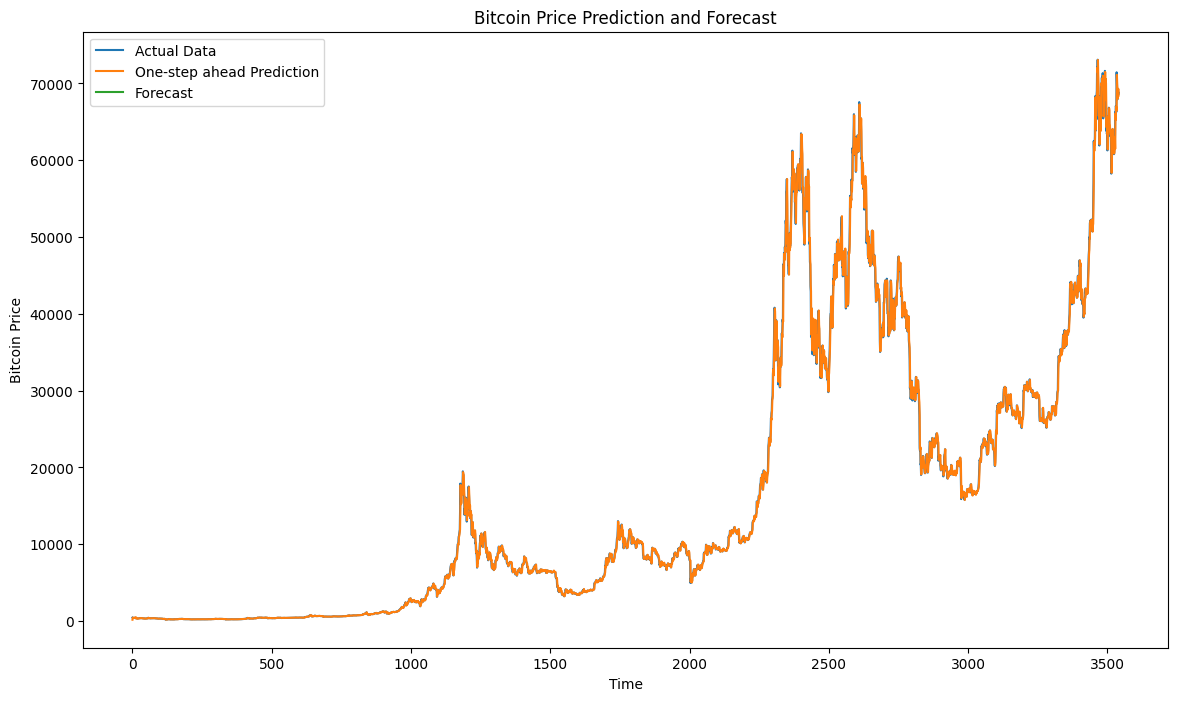

In [40]:
# Plot observed vs. predicted values
true = mm.inverse_transform(y_trans.reshape(-1, 1)).flatten()
preds = mm.inverse_transform(results.get_prediction(start=0, end=len(y_trans)-1).predicted_mean.reshape(-1, 1)).flatten()

plt.figure(figsize=(14, 8))
plt.plot(true, label='Actual Data')
plt.plot(preds, label='One-step ahead Prediction')
forecast_index = np.arange(len(y_trans), len(y_trans) + forecast_steps)
plt.plot(forecast_index, predicted_price_scaled, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction and Forecast')
plt.legend()
plt.show()

# Tomorrow's Prediction

In [41]:
# Print the predicted price for tomorrow
print(f"Predicted Bitcoin price for tomorrow: ${predicted_price_scaled[0]:.2f}")

Predicted Bitcoin price for tomorrow: $68884.56


# Mean Squared Error (MSE) loss

In [42]:
# Convert tensors
y_test_tensors = torch.Tensor(y_trans[-forecast_steps:])
y_pred_tensors = torch.Tensor(forecast_mean)

# Calculate MSE Loss
mse_loss = torch.nn.MSELoss()(y_pred_tensors, y_test_tensors).item()
print(f"Test Loss (MSE): {mse_loss}")

Test Loss (MSE): 1.790257556422148e-06


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Mean Absolute Error (MAE)

In [43]:
mae = l1_loss(y_pred_tensors, y_test_tensors, reduction='mean').item()
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.0013380050659179688


<ipython-input-43-74aeb1c01458>:1: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = l1_loss(y_pred_tensors, y_test_tensors, reduction='mean').item()


# R-squared

In [44]:
# Calculate R-squared
r_squared = r2_score(mm.inverse_transform(y_test_tensors.reshape(-1, 1)), predicted_price_scaled.reshape(-1, 1))
print(f"R-squared: {r_squared}")

R-squared: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# Mean Absolute Percentage Error (MAPE)

In [45]:
# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred, eps=1e-8):
    y_true, y_pred = torch.tensor(y_true), torch.tensor(y_pred)
    mape = torch.mean(torch.abs((y_true - y_pred) / torch.clamp(y_true, min=eps)))
    return mape

mape = mean_absolute_percentage_error(mm.inverse_transform(y_test_tensors.reshape(-1, 1)), predicted_price_scaled.reshape(-1, 1)).item()
print(f"Mean Absolute Percentage Error: {mape}")

Mean Absolute Percentage Error: 0.0014180836827586247
